In [185]:
import numpy as np
import pandas as pd
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table
import itertools
from astroquery.simbad import Simbad
from utils import PLOT_PARAMS
from astropy import constants as const

PLOT_PARAMS()
from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)
import pickle

plt.rcParams['figure.facecolor'] = 'white'
import warnings
warnings.filterwarnings("ignore")

from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

vlt = EarthLocation.of_site('paranal')  # the easiest way... but requires internet

05_05_25


In [2]:
galah = Table.read('../../lithium/data/GALAH_DR3_main_allstar_v2.fits').to_pandas()

In [559]:
galah_vac = Table.read('../../lithium/data/GALAH_DR3_VAC_ages_v2.fits').to_pandas()

In [3]:
rv_df = pd.read_csv('comb_rvs.csv')

In [11]:
binary_list_113 = 7, 9, 11, 16, 18, 19, 21, 23  
binary_list_112 = 6, 7, 13, 23

In [36]:
def load_samples(df0,program,binary_list):
    stat_dict = {}        
    version = 1
    
    df = df0[df0.program==program]
    
    dtemp = {'RG_id':[],
             'P16':[], 'P50':[], 'P84':[],
             'e16':[], 'e50':[], 'e84':[],
             'K16':[], 'K50':[], 'K84':[] }
    
    for i, row in df.iterrows():
        RG = row.RG_id
        
        if RG not in binary_list:
            continue
        fname = '../mcmc/%s_%s_mcmc_%s.pickle'%(program,RG,version)

        with open(fname, 'rb') as handle:
            mcmc_samples = pickle.load(handle)
        
        Ps = mcmc_samples['P'].value
        es = mcmc_samples['e'].value
        Ks = mcmc_samples['K'].value
        
        dtemp['RG_id'].append(RG)
        
        dtemp['P16'].append(np.percentile(Ps, 16))
        dtemp['P50'].append(np.percentile(Ps, 50))
        dtemp['P84'].append(np.percentile(Ps, 84))
        
        dtemp['e16'].append(np.percentile(es, 16))
        dtemp['e50'].append(np.percentile(es, 50))
        dtemp['e84'].append(np.percentile(es, 84))
        
        dtemp['K16'].append(np.percentile(Ks, 16))
        dtemp['K50'].append(np.percentile(Ks, 50))
        dtemp['K84'].append(np.percentile(Ks, 84))
    
    dtemp = pd.DataFrame(dtemp)
    
    dtemp = pd.merge(dtemp, df)
    
    return dtemp

temp1 = load_samples(rv_df, 112, binary_list_112)
temp2 = load_samples(rv_df, 113, binary_list_113)


In [37]:
table1 = pd.concat([temp1, temp2])

# get mass from galah
table1 = pd.merge(table1, galah_vac[['sobject_id','m_act_bstep','e_m_act_bstep']], left_on='sobject_id', right_on='sobject_id')

In [88]:
def get_msini(df0,program,binary_list):
    version = 1
    df = df0[df0.program==program]

    dtemp = {'RG_id':[], 'Mj16':[], 'Mj50':[], 'Mj84':[], 
             'a16': [], 'a50':[], 'a84':[]
            }
    for i, row in df.iterrows():
        RG = row.RG_id
        
        if RG not in binary_list:
            continue
        fname = '../mcmc/%s_%s_mcmc_%s.pickle'%(program,RG,version)

        with open(fname, 'rb') as handle:
            mcmc_samples = pickle.load(handle)

        Ks = mcmc_samples['K'].value
        Ps = mcmc_samples['P'].value
        es = mcmc_samples['e'].value
        
        Mstar = np.array(df[(df.RG_id==RG)].m_act_bstep)[0]
        
        if str(Mstar) == 'nan':
            if df.sobject_id.values[0] == 190212001601338: # gaia DR3 3217773074208416640
                Mstar = 1.070
               
        Mjup = np.empty(len(Ks))
        a_au = np.empty(len(Ks))
        
        for i in range(len(Ks)):
            K, P, e = Ks[i], Ps[i], es[i]
            Msini, success = msini_func(K, P, e, Mstar)
            Msini_jup   = Msini/u.M_jup.to(u.kg)
            Mjup[i] = Msini_jup[0]
            
            a_m  = semi_major_axis(M1=Mstar, M2=Msini_jup, P=P)

            a_au[i] = a_m.to(u.au).value
        
        dtemp['RG_id'].append(RG)
        
        dtemp['Mj16'].append(np.percentile(Mjup, 16))
        dtemp['Mj50'].append(np.percentile(Mjup, 50))
        dtemp['Mj84'].append(np.percentile(Mjup, 84))
        
        dtemp['a16'].append(np.percentile(a_au, 16))
        dtemp['a50'].append(np.percentile(a_au, 50))
        dtemp['a84'].append(np.percentile(a_au, 84))

    dtemp = pd.DataFrame(dtemp)
    dtemp = pd.merge(dtemp, df)
    
    return dtemp

mass_temp1 = get_msini(table1, 112, binary_list_112)
mass_temp2 = get_msini(table1, 113, binary_list_113)

table2 = pd.concat([mass_temp1, mass_temp2])

In [74]:
def semi_major_axis(M1, M2, P):
    '''
    M1 : in solar masses
    P : in days
    M2 : in Mjup
    
    @return a: m
    
    '''
    G = const.G
    M1 = (M1*u.Msun).to(u.kg)
    M2 = (M2*u.Mjup).to(u.kg)
    M = (M1+M2)
    P = (P*u.day).to(u.second)
    a = (G*M*P**2/(4*np.pi**2))**(1./3)
    
    return a


In [99]:
def v_max(df):
    '''
    M1 in solar units
    M2 in Mjup units
    a in AU
    
    return v_max in km/s
    
    '''
    M1, M2 = df.m_act_bstep.to_numpy(), df.Mj50.to_numpy()
    a, e = df.a50.to_numpy(), df.e50.to_numpy()
    
    M1 = (M1*u.Msun).to(u.kg)
    M2 = (M2*u.Mjup).to(u.kg)
    M = (M1+M2)
    a = (a*u.au).to(u.m)
    M = (M1+M2)
    G = const.G

    v = ((G*M/a) * (2./(1-e) - 1))
    v = [np.sqrt(i.value) for i in v]
    v = [(i*u.m/u.s).to(u.km/u.s).value for i in v]
    
    df['v_max'] = v
    
    return df

In [100]:

def v_orb(df):
    '''
    a: in meters
    P: in days
    
    v_orb : in km/s
    
    '''
    a, P = df.a50.to_numpy(), df.P50.to_numpy()
    
    a = (a*u.au).to(u.m)
    P = (P*u.day).to(u.second)

    v = 2*np.pi*a/P
    v = [i.to(u.km/u.s).value for i in v]
    df['v_orb'] = v
    return df


In [30]:
def msini_func(K, P, e, Mstar):
    '''
    Get Mp sin(i), the minimum mass of the companion.
    @input:
        K: semi-amplitude in km/s
        P: period in days
        e: eccentricity
        M: mass of the star in solar masses
    
    '''
    from scipy import optimize
    
    # convert units to SI units
    K = (K*(u.km/u.second)).to(u.meter/u.second)
    P = (P*u.day).to(u.second)
    Mstar = (Mstar*u.M_sun).to(u.kg)
    e = e*u.dimensionless_unscaled
    
    # define constants
    pi = np.pi
    G  = const.G
    
    # if Mp << Mstar:
    Msini = (Mstar)**(2./3.) * np.sqrt(1-e**2.) * K * (P/(2*pi*G))**(1./3.)
    
    # else:
    a = np.sqrt(1-e**2.) * K * (P/(2*pi*G))**(1./3.)
    #Msini = (Mstar+Mp)**(2./3.) * a
    #fx = (Mstar+Mp)**(2./3.) * a - Msini
    
    Mjup = u.M_jup.to(u.kg)
    Msun = u.Msun.to(u.kg)
    #print(Mjup)
    def func(x, a, Mstar):
        return x - (Mstar + x)**(2./3.) * a # x = Msini

    from scipy.optimize import brentq, bisect, fsolve
    from scipy.optimize import fsolve

    sol   = optimize.root(func, Msun, args=(a.value, Mstar.value) )
    Msini = sol.x
    
    #root  = brentq(func, 0.1, Msun , args=(a.value, Mstar.value))
    
    return Msini, sol.success


In [123]:
table4 = table2.copy()

In [124]:
table4 = v_max(table4)
table4 = v_orb(table4)

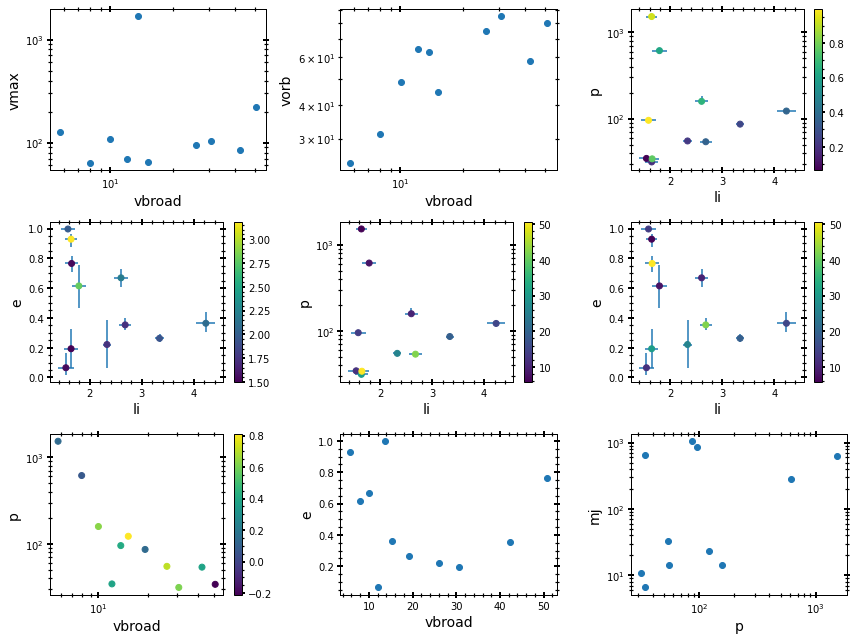

In [186]:
table3 = table4[~((table4.RG_id==23) & (table4.program==112))]

plt.figure(figsize=(12,9))
plt.subplot(331)
plt.scatter(table3.vbroad,table3.v_max)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('vbroad')
plt.ylabel('vmax')

plt.subplot(332)
plt.scatter(table3.vbroad,table3.v_orb)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('vbroad')
plt.ylabel('vorb')

plt.subplot(333)
plt.errorbar(table3.Li_val, table3.P50, xerr=table3.e_Li_val,yerr=[table3.P50-table3.P16,table3.P84-table3.P50],fmt='o',mfc='None',mec='None')
plt.scatter(table3.Li_val, table3.P50,c=table3.e50.to_numpy(),zorder=100)
plt.colorbar()
plt.xlabel('li')
plt.ylabel('p')
plt.yscale('log')

plt.subplot(334)
plt.errorbar(table3.Li_val, table3.e50, xerr=table3.e_Li_val, yerr=[table3.e50-table3.e16,table3.e84-table3.e50],fmt='o',mfc='None',mec='None')
plt.scatter(table3.Li_val, table3.e50,c=np.log10(table3.P50.to_numpy()),zorder=100)
plt.colorbar()
plt.xlabel('li')
plt.ylabel('e')


plt.subplot(335)
plt.errorbar(table3.Li_val, table3.P50, xerr=table3.e_Li_val,yerr=[table3.P50-table3.P16,table3.P84-table3.P50],fmt='o',mfc='None',mec='None')
plt.scatter(table3.Li_val, table3.P50,c=table3.vbroad.to_numpy(),zorder=100)
plt.colorbar()
plt.xlabel('li')
plt.ylabel('p')
plt.yscale('log')


plt.subplot(336)
plt.errorbar(table3.Li_val, table3.e50, xerr=table3.e_Li_val, yerr=[table3.e50-table3.e16,table3.e84-table3.e50],fmt='o',mfc='None',mec='None')
plt.scatter(table3.Li_val, table3.e50,c=table3.vbroad.to_numpy(),zorder=100)
plt.colorbar()
plt.xlabel('li')
plt.ylabel('e')

plt.subplot(337)
plt.scatter(table3.vbroad, table3.P50,c=table3.Ba_fe)
plt.colorbar()
plt.xlabel('vbroad')
plt.ylabel('p')
plt.yscale('log')
plt.xscale('log')


plt.subplot(338)
plt.scatter(table3.vbroad, table3.e50)
plt.ylabel('e')
plt.xlabel('vbroad')


plt.subplot(339)
plt.scatter(table3.P50, (table3.Mj50*u.Mjup))
plt.xscale('log')
plt.yscale('log')
plt.ylabel('mj')
plt.xlabel('p')

plt.tight_layout()

In [222]:
table3.keys()

Index(['RG_id', 'Mj16', 'Mj50', 'Mj84', 'a16', 'a50', 'a84', 'P16', 'P50',
       'P84', 'e16', 'e50', 'e84', 'K16', 'K50', 'K84', 'sobject_id', 'logg',
       'teff', 'galah_id', 'obj_name', 'esp_time', 'esp_rv', 'esp_rv_err',
       'Li_val', 'e_Li_val', 'vbroad', 'e_vbroad', 'fe_h', 'ruwe_dr2', 'Ba_fe',
       'e_Ba_fe', 'La_fe', 'e_La_fe', 'Zr_fe', 'e_Zr_fe', 'Y_fe', 'e_Y_fe',
       'program', 'ra_dr2', 'dec_dr2', 'dr3_source_id', 'MJD_local',
       'rv_nogr_obst', 'e_rv_nogr_obst', 'rv_galah', 'e_rv_galah', 'comb_time',
       'comb_rv', 'comb_rv_err', 'm_act_bstep', 'e_m_act_bstep', 'v_max',
       'v_orb'],
      dtype='object')

In [236]:
PLOT_PARAMS()

In [303]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


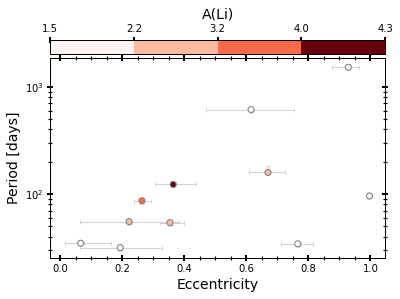

In [358]:
bounds = [1.5, 2.2, 3.2, 4, 4.3]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'A(Li)'

fig=plt.figure(figsize=(6,4))
ax1=plt.subplot(111)
plt.errorbar(table3.e50, table3.P50,color='lightgrey', xerr=[table3.e50-table3.e16,table3.e84-table3.e50],
            yerr=[table3.P50-table3.P16,table3.P84-table3.P50],capsize=2, fmt='o',mec=None,mfc=None,zorder=-100,lw=1)

im1=plt.scatter(table3.e50, table3.P50, c=table3.Li_val,cmap=cmap, norm=norm,ec='grey')

ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax1.xaxis.set_ticks_position("top") # change tick position to top
cb1.ax.set_title(clabel)

ax1.set_yscale('log')
ax1.set_xlabel('Eccentricity')
ax1.set_ylabel('Period [days]')
# plt.savefig('../plots/e_P_li_%s.png'%DATE,bbox_inches='tight',dpi=200)


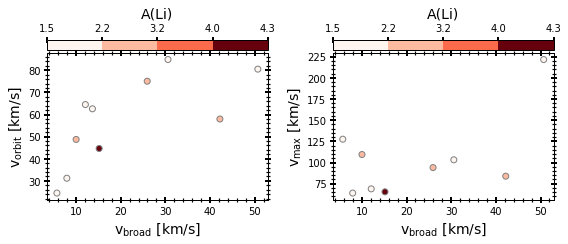

In [331]:

# a_all.v_max.to_numpy()[0].to(u.km/u.hour)
bounds = [1.5, 2.2, 3.2, 4, 4.3]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'A(Li)'

plt.figure(figsize=(8,3.5))
ax1=plt.subplot(121)
im1=plt.scatter(table3.vbroad, table3.v_orb, c=table3.Li_val, cmap=cmap, norm=norm,ec='grey')
plt.xlabel('v$_\mathrm{broad}$ [km/s]')

plt.ylabel('v$_\mathrm{orbit}$ [km/s]')

line=np.linspace(min(table3.vbroad),max(table3.vbroad),1000)
# plt.plot(line,line,c='k')

ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax1.xaxis.set_ticks_position("top") # change tick position to top
cb1.ax.set_title(clabel)

ax2=plt.subplot(122)
im2=plt.scatter(table3[table3.v_max<1000].vbroad,table3[table3.v_max<1000].v_max, c=table3[table3.v_max<1000].Li_val, cmap=cmap, norm=norm,ec='grey')
plt.xlabel('v$_\mathrm{broad}$ [km/s]')
plt.ylabel('v$_\mathrm{max}$ [km/s]')

ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb2 = fig.colorbar(im2, cax=cax2, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax2.xaxis.set_ticks_position("top") # change tick position to top
cb2.ax.set_title(clabel)

# ax2.set_xscale('log')
# ax2.set_yscale('log')


plt.tight_layout()
# plt.savefig('../plots/vbroad_vmax_vorb_%s.png'%DATE,bbox_inches='tight',dpi=200)
plt.show()

In [301]:
from matplotlib import colors

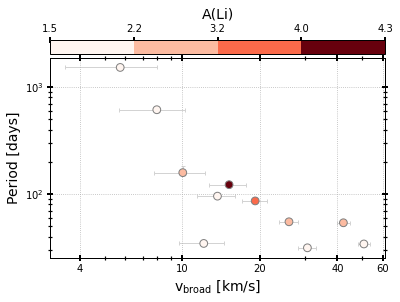

In [391]:
bounds = [1.5, 2.2, 3.2, 4, 4.3]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'A(Li)'

fig=plt.figure(figsize=(6,4))
ax1=plt.subplot(111)
plt.errorbar(table3.vbroad, table3.P50, xerr=table3.e_vbroad,
             yerr=[table3.P50-table3.P16,table3.P84-table3.P50],
             capsize=2, fmt='o',mec=None,mfc=None,zorder=-100,lw=1,color='lightgrey')

im1=plt.scatter(table3.vbroad, table3.P50, c=table3.Li_val,cmap=cmap, norm=norm,ec='grey',s=60)

ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax1.xaxis.set_ticks_position("top") # change tick position to top
cb1.ax.set_title(clabel)

ax1.set_yscale('log')
ax1.set_xscale('log')
xticks = [4, 10, 20,40, 60]
xlabels = ['%i' %x for x in xticks]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xlabels)


ax1.set_xlabel('v$_{\mathrm{broad}}$ [km/s]')
ax1.set_ylabel('Period [days]')
ax1.grid(ls='dotted')
ax1.set_ylim(25.44715063069063, 1858.443368942767)
ax1.set_xlim(3.063198120106046, 61.2462833430784)

# plt.savefig('../plots/a1_%s.png'%DATE,bbox_inches='tight',dpi=200)


(6.587178948708015, 1047.5655146604772)

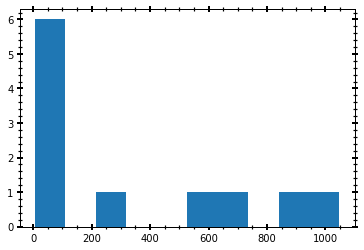

In [384]:
plt.hist(table3.Mj50)
min(table3.Mj50),max(table3.Mj50)

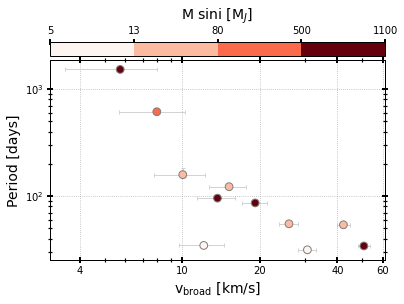

In [395]:
bounds = [5,13,80,500,1100]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'M sini [M$_J$]'

fig=plt.figure(figsize=(6,4))
ax1=plt.subplot(111)
plt.errorbar(table3.vbroad, table3.P50, xerr=table3.e_vbroad,
             yerr=[table3.P50-table3.P16,table3.P84-table3.P50],
             capsize=2, fmt='o',mec=None,mfc=None,zorder=-100,lw=1,color='lightgrey')

im1=plt.scatter(table3.vbroad, table3.P50, c=table3.Mj50,cmap=cmap, norm=norm,ec='grey',s=60)

ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax1.xaxis.set_ticks_position("top") # change tick position to top
cb1.ax.set_title(clabel)

ax1.set_yscale('log')
ax1.set_xscale('log')
xticks = [4, 10, 20,40, 60]
xlabels = ['%i' %x for x in xticks]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xlabels)


ax1.set_xlabel('v$_{\mathrm{broad}}$ [km/s]')
ax1.set_ylabel('Period [days]')
ax1.grid(ls='dotted')
ax1.set_ylim(25.44715063069063, 1858.443368942767)
ax1.set_xlim(3.063198120106046, 61.2462833430784)

# plt.savefig('../plots/a2_%s.png'%DATE,bbox_inches='tight',dpi=200)


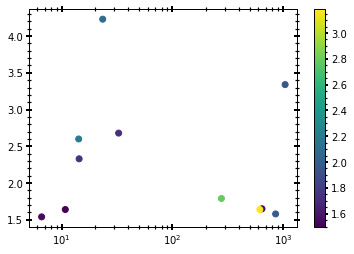

In [401]:
plt.scatter(table3.Mj50, table3.Li_val,c=np.log10(table3.P50))
plt.colorbar()
plt.xscale('log')

(array([6., 2., 0., 0., 1., 0., 0., 0., 0., 1.]),
 array([0.20527431, 0.52813239, 0.85099047, 1.17384855, 1.49670663,
        1.81956471, 2.14242279, 2.46528087, 2.78813895, 3.11099703,
        3.43385511]),
 <BarContainer object of 10 artists>)

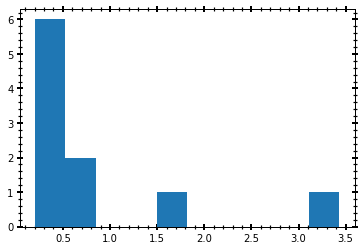

In [436]:
plt.hist(table3.a50)#bins=[0,0.25,0.5,0.75,1.])

(array([3., 3., 2., 3.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 <BarContainer object of 4 artists>)

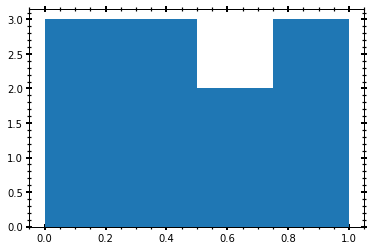

In [421]:
plt.hist(table3.e50,bins=[0,0.25,0.5,0.75,1.])

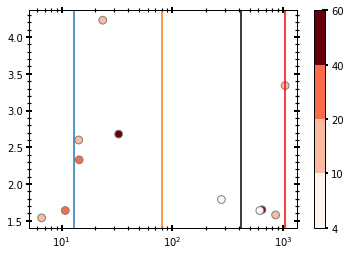

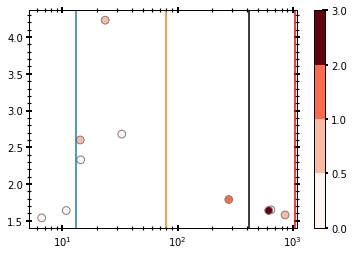

In [438]:
bounds = [0,0.25,0.5,0.75,1.]
bounds = [1.5, 2.2, 3.2, 4, 4.3]
bounds = [4,10,20,40,60]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'li'

plt.subplot(111)
plt.scatter(table3.Mj50, table3.Li_val,c=table3.vbroad,cmap=cmap,norm=norm,ec='grey',s=60)
plt.colorbar()
plt.xscale('log')

plt.axvline(13,c='C0')
plt.axvline(80,c='C1')
plt.axvline(msolar,c='r')
plt.axvline(0.4*msolar,c='k')


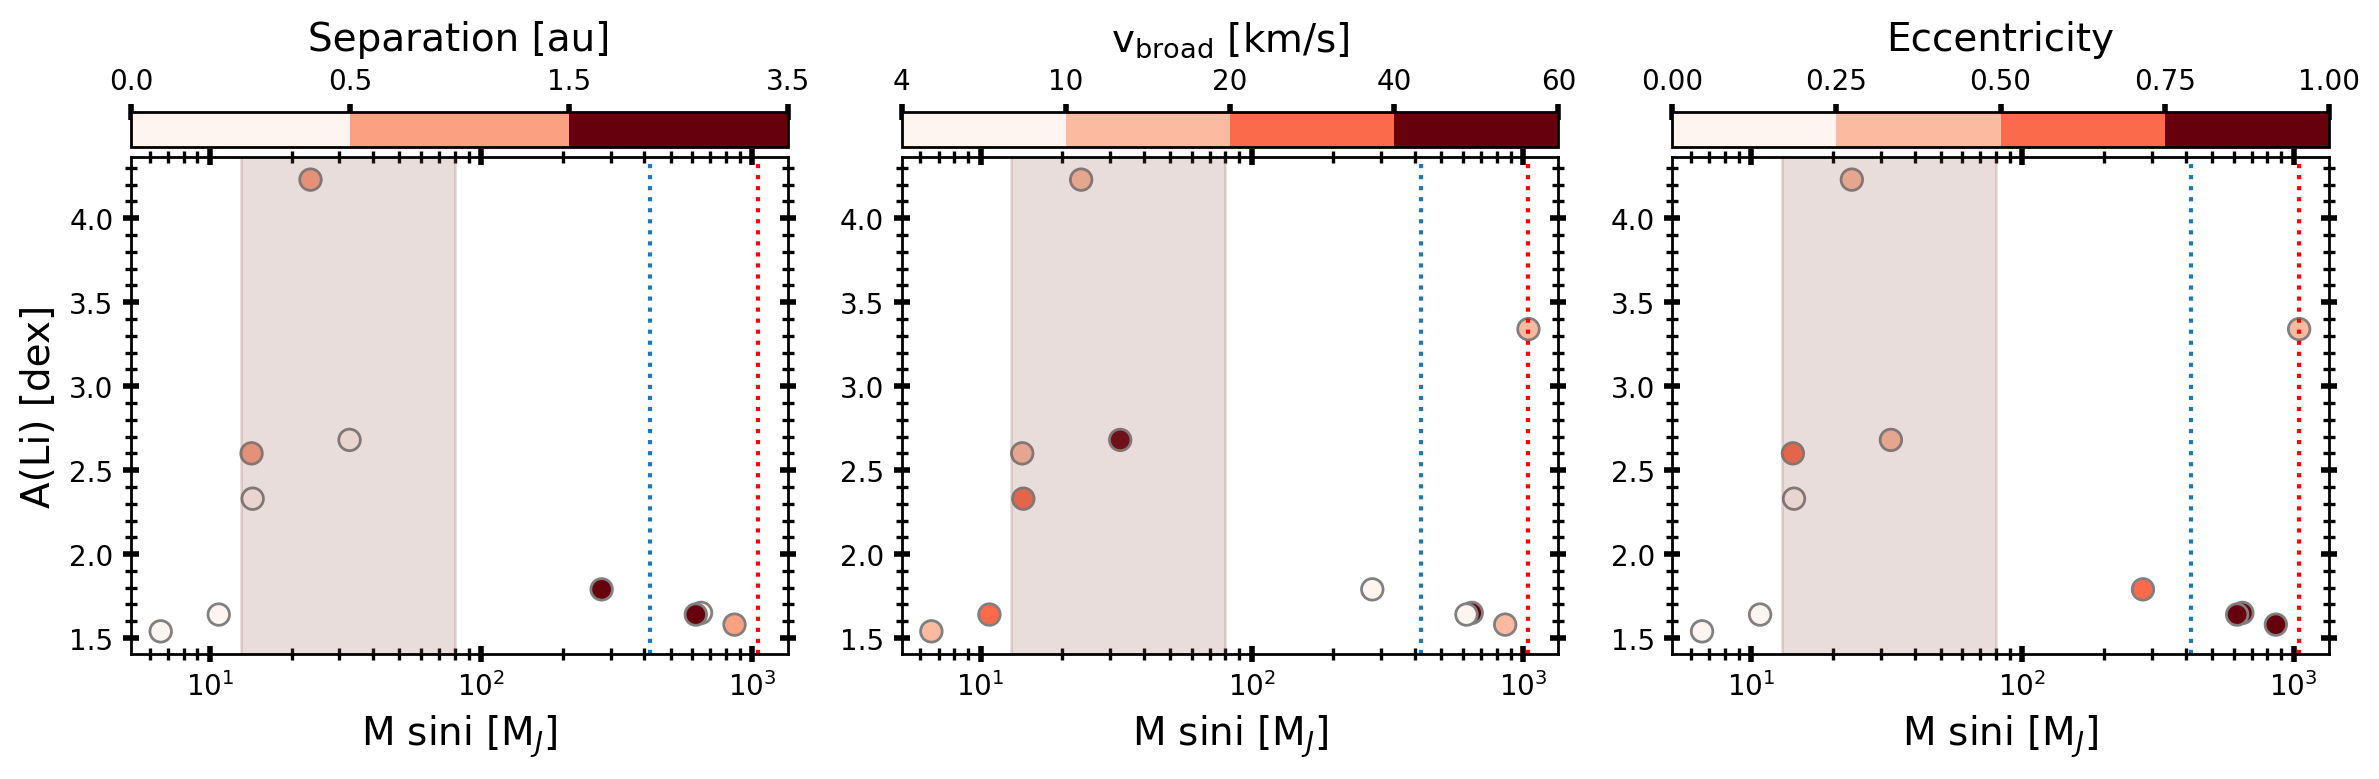

In [472]:
plt.figure(figsize=(12,4),dpi=200)
bounds = [0,0.5,1.5,3.5]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'Separation [au]'

ax1=plt.subplot(131)
im1=plt.scatter(table3.Mj50, table3.Li_val,c=table3.a50,cmap=cmap,norm=norm,ec='grey',s=60)
plt.xscale('log')
plt.axvspan(13, 80, color='tab:brown', alpha=0.2, label='Brown Dwarf')
ax1.set_ylabel('A(Li) [dex]')
ax1.set_xlabel('M sini [M$_J$]')
# plt.ylim(4.4,1800)
plt.axvline(msolar,c='r',ls='dotted')
plt.axvline(0.4*msolar,c='C0',ls='dotted')

ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax1.xaxis.set_ticks_position("top") # change tick position to top
cb1.ax.set_title(clabel)

ax1=plt.subplot(132,sharex=ax1,sharey=ax1)
bounds = [4,10,20,40,60]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'v$_{\mathrm{broad}}$ [km/s]'

im1=plt.scatter(table3.Mj50, table3.Li_val,c=table3.vbroad,cmap=cmap,norm=norm,ec='grey',s=60)
plt.xscale('log')

plt.axvspan(13, 80, color='tab:brown', alpha=0.2, label='Brown Dwarf')
plt.axvline(msolar,c='r',ls='dotted')
plt.axvline(0.4*msolar,c='C0',ls='dotted')

ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax1.xaxis.set_ticks_position("top") # change tick position to top
cb1.ax.set_title(clabel)
ax1.set_xlabel('M sini [M$_J$]')

ax1=plt.subplot(133,sharex=ax1,sharey=ax1)
bounds = [0,0.25,0.5,0.75,1.0]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'Eccentricity'

im1=plt.scatter(table3.Mj50, table3.Li_val,c=table3.e50,cmap=cmap,norm=norm,ec='grey',s=60)
plt.xscale('log')

plt.axvspan(13, 80, color='tab:brown', alpha=0.2, label='Brown Dwarf')
plt.axvline(msolar,c='r',ls='dotted')
plt.axvline(0.4*msolar,c='C0',ls='dotted')

ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax1.xaxis.set_ticks_position("top") # change tick position to top
cb1.ax.set_title(clabel)
ax1.set_xlabel('M sini [M$_J$]')

plt.tight_layout()

In [ ]:
table3

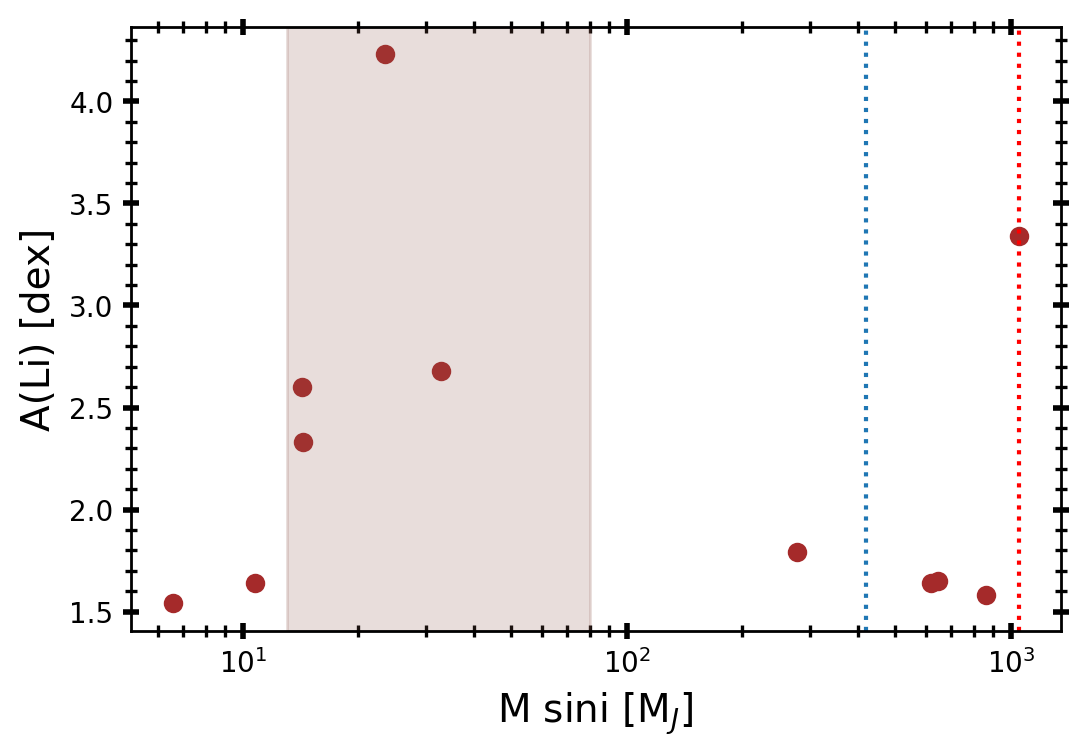

In [491]:
plt.figure(figsize=(6,4),dpi=200)
plt.scatter(table3.Mj50, table3.Li_val,c=color)
plt.ylabel('A(Li) [dex]')
plt.xlabel('M sini [M$_J$]')
plt.xscale('log')

plt.axvspan(13, 80, color='tab:brown', alpha=0.2, label='Brown Dwarf')
plt.axvline(msolar,c='r',ls='dotted')
plt.axvline(0.4*msolar,c='C0',ls='dotted')

plt.show()

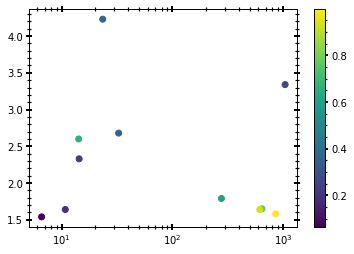

In [469]:
plt.scatter(table3.Mj50, table3.Li_val,c=table3.e50)
plt.colorbar()
plt.xscale('log')

(3.063198120106046, 61.2462833430784)

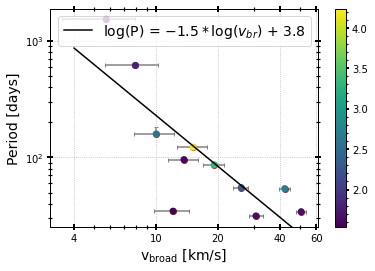

In [374]:
plt.figure(figsize=(6,4))
color='brown'
ax1=plt.subplot(111)
plt.errorbar(table3.vbroad, table3.P50, xerr=table3.e_vbroad,
             yerr=[table3.P50-table3.P16,table3.P84-table3.P50],
             fmt='o',c='grey',mfc=color,mec=color,capsize=2)#,c=table3.Ba_fe)
# plt.colorbar()
plt.xlabel('v$_{\mathrm{broad}}$ [km/s]')
plt.ylabel('Period [days]')
plt.yscale('log')
plt.xscale('log')

def func(x, m, b):
    
    return m*x + b

from scipy.optimize import curve_fit

xdata,ydata = table3.vbroad.to_numpy(), table3.P50.to_numpy()
mask = np.argsort(xdata)
xdata,ydata = xdata[mask],ydata[mask]
xlog, ylog = np.log10(xdata),np.log10(ydata)
popt, pcov = curve_fit(func, xlog, ylog)

xvals = np.log10(np.linspace(4, 60, 100))
xticks = [4, 10, 20,40, 60]
xlabels = ['%i' %x for x in xticks]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xlabels)
plt.grid(ls='dotted')

plt.plot(10.**xvals, 10.**func(xvals, *popt), 'k-',
         label='log(P) = $%.1f*\log(v_{br}$) + %.1f' % tuple(popt))
# print(plt.ylim())
# print(plt.xlim())
plt.legend(loc='upper right')
plt.ylim(25.44715063069063, 1858.443368942767)
plt.xlim(3.063198120106046, 61.2462833430784)
# plt.savefig('../plots/b.png',bbox_inches='tight',dpi=200)

(4.4, 1800)

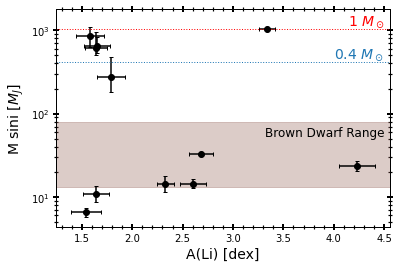

In [245]:
plt.figure(figsize=(6,4))
plt.errorbar(table3.Li_val, (table3.Mj50*u.Mjup), 
             xerr=table3.e_Li_val,
             yerr=[table3.Mj50-table3.Mj16,table3.Mj84-table3.Mj50],
             fmt='o',capsize=2, c='k')
plt.yscale('log')
plt.ylabel('M sini [$M_J$]')
plt.xlabel('A(Li) [dex]')

mearth = (u.Mjup).to(u.Mearth)
msolar = (u.Msun).to(u.Mjup)
xi = 4.5
plt.axhline(msolar,c='r',ls='dotted',lw=1,label='1 $M_\odot$')
plt.text(xi, msolar, s='1 $M_\odot$', ha='right',va='bottom', c='r',fontsize=14)

plt.axhline(0.4*msolar,c='C0',ls='dotted',lw=1, label='0.4 $M_\odot$')
plt.text(xi, 0.4*msolar, s='0.4 $M_\odot$', ha='right',va='bottom', c='C0',fontsize=14)

#plt.axhline(mearth,c='C1',ls='dotted',lw=1,label='1 $M_\oplus$')
#plt.text(4.5, mearth, s='1 $M_\oplus$', ha='right',va='top', c='C1',fontsize=14)

plt.axhspan(13, 80, color='tab:brown', alpha=0.3, label='Brown Dwarf')
plt.text(xi, 70, s='Brown Dwarf Range', ha='right',va='top', c='k',fontsize=12)
plt.ylim(4.4,1800)


(4.4, 1800)

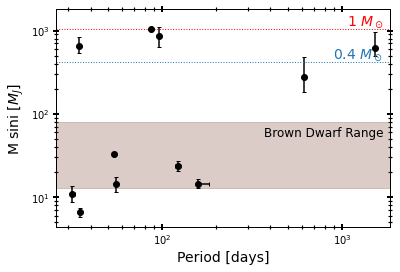

In [246]:
plt.figure(figsize=(6,4))
plt.errorbar(table3.P50, (table3.Mj50*u.Mjup), 
             xerr=[table3.P50-table3.P16,table3.P84-table3.P50],
             yerr=[table3.Mj50-table3.Mj16,table3.Mj84-table3.Mj50],
             fmt='o',capsize=2, c='k')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('M sini [$M_J$]')
plt.xlabel('Period [days]')

mearth = (u.Mjup).to(u.Mearth)
msolar = (u.Msun).to(u.Mjup)
xi = 1700
plt.axhline(msolar,c='r',ls='dotted',lw=1,label='1 $M_\odot$')
plt.text(xi, msolar, s='1 $M_\odot$', ha='right',va='bottom', c='r',fontsize=14)

plt.axhline(0.4*msolar,c='C0',ls='dotted',lw=1, label='0.4 $M_\odot$')
plt.text(xi, 0.4*msolar, s='0.4 $M_\odot$', ha='right',va='bottom', c='C0',fontsize=14)

#plt.axhline(mearth,c='C1',ls='dotted',lw=1,label='1 $M_\oplus$')
#plt.text(4.5, mearth, s='1 $M_\oplus$', ha='right',va='top', c='C1',fontsize=14)

plt.axhspan(13, 80, color='tab:brown', alpha=0.3, label='Brown Dwarf')
plt.text(xi, 70, s='Brown Dwarf Range', ha='right',va='top', c='k',fontsize=12)
plt.ylim(4.4,1800)


In [173]:
table3[['RG_id','program','P50','v_max','e50','vbroad','e50']].sort_values(by='P50')

,RG_id,program,P50,v_max,e50,vbroad,e50
2,11,113,31.517923,103.180227,0.193047,30.59,0.193047
3,16,113,34.236376,221.572751,0.765700,50.70,0.765700
1,9,113,34.620994,68.876268,0.065456,12.10,0.065456
5,19,113,54.001598,83.848101,0.353373,42.21,0.353373
6,21,113,55.167827,94.008600,0.221503,25.94,0.221503
2,13,112,86.425657,NaN,0.263000,19.17,0.263000
4,18,113,95.724711,1673.255420,0.997206,13.68,0.997206
0,7,113,122.559742,65.365230,0.364026,15.18,0.364026
1,7,112,158.760071,109.447640,0.669294,10.03,0.669294
0,6,112,614.328998,63.903097,0.615072,7.95,0.615072


In [188]:
def clean_up(df):
    time = df['comb_time']
    rv = df['comb_rv']
    err = df['comb_rv_err']
    
    time = time.values[0].split('[')[-1].split(']')[0].split(' ')#[:-1]
    time = [t for t in time if len(t) > 0]
    time = [float(t.split('\n')[0]) for t in time]
    
    rv = rv.values[0].split('[')[-1].split(']')[0].split(' ')#[:-1]
    rv = [t for t in rv if len(t) > 0]
    rv = [float(t.split('\n')[0]) for t in rv]
    
    err = err.values[0].split('[')[-1].split(']')[0].split(' ')#[:-1]
    err = [t for t in err if len(t) > 0]
    err = [float(t.split('\n')[0]) for t in err]
    
    return time, rv, err

clean_up(rv_df[(rv_df.RG_id==1) & (rv_df.program==112)])


([2460341.53519178,
  2460389.56581584,
  2460371.51348333,
  2460303.84853621,
  2457030.1328125],
 [53.7010931, 53.79850384, 53.71577284, 53.45877222, 53.57600021],
 [0.03563532, 0.0194216, 0.01884311, 0.00615718, 0.071])

In [195]:
def plot_joker_samples(df, obj, program, ax, version=1):
#     if (obj==16 or obj==11) and program=='p113':
#         version = 2
#     else:
    dftemp  = df[(df.RG_id==obj) & (rv_df.program==program)]

    fname   = '../mcmc/%s_%s_joker_%s.hdf5'%(program,obj,version)
    joker_samples = tj.JokerSamples.read(fname)
    
    time, rv, rv_err = clean_up(dftemp)
    
    data = Table()
    data['bjd']     = time
    data['rv']      = rv
    data['rv_err']  = rv_err
    data["rv"].unit = u.km / u.s
    data["rv_err"].unit = u.km / u.s
    
    data = tj.RVData(
        t=Time(data["bjd"], format="jd", scale="tcb"),
        rv=u.Quantity(data["rv"]),
        rv_err=u.Quantity(data["rv_err"]))
    PLOT_PARAMS()

    _ = tj.plot_rv_curves(joker_samples, data=data, ax=ax)
    if program==112:
        ax.text(0.5, 0.9, '112 - RG %s'%obj, transform=ax.transAxes,fontsize=14, ha='center')
    else:
        ax.text(0.5, 0.9, '113 - RG %s'%obj, transform=ax.transAxes,fontsize=14, ha='center',)
    


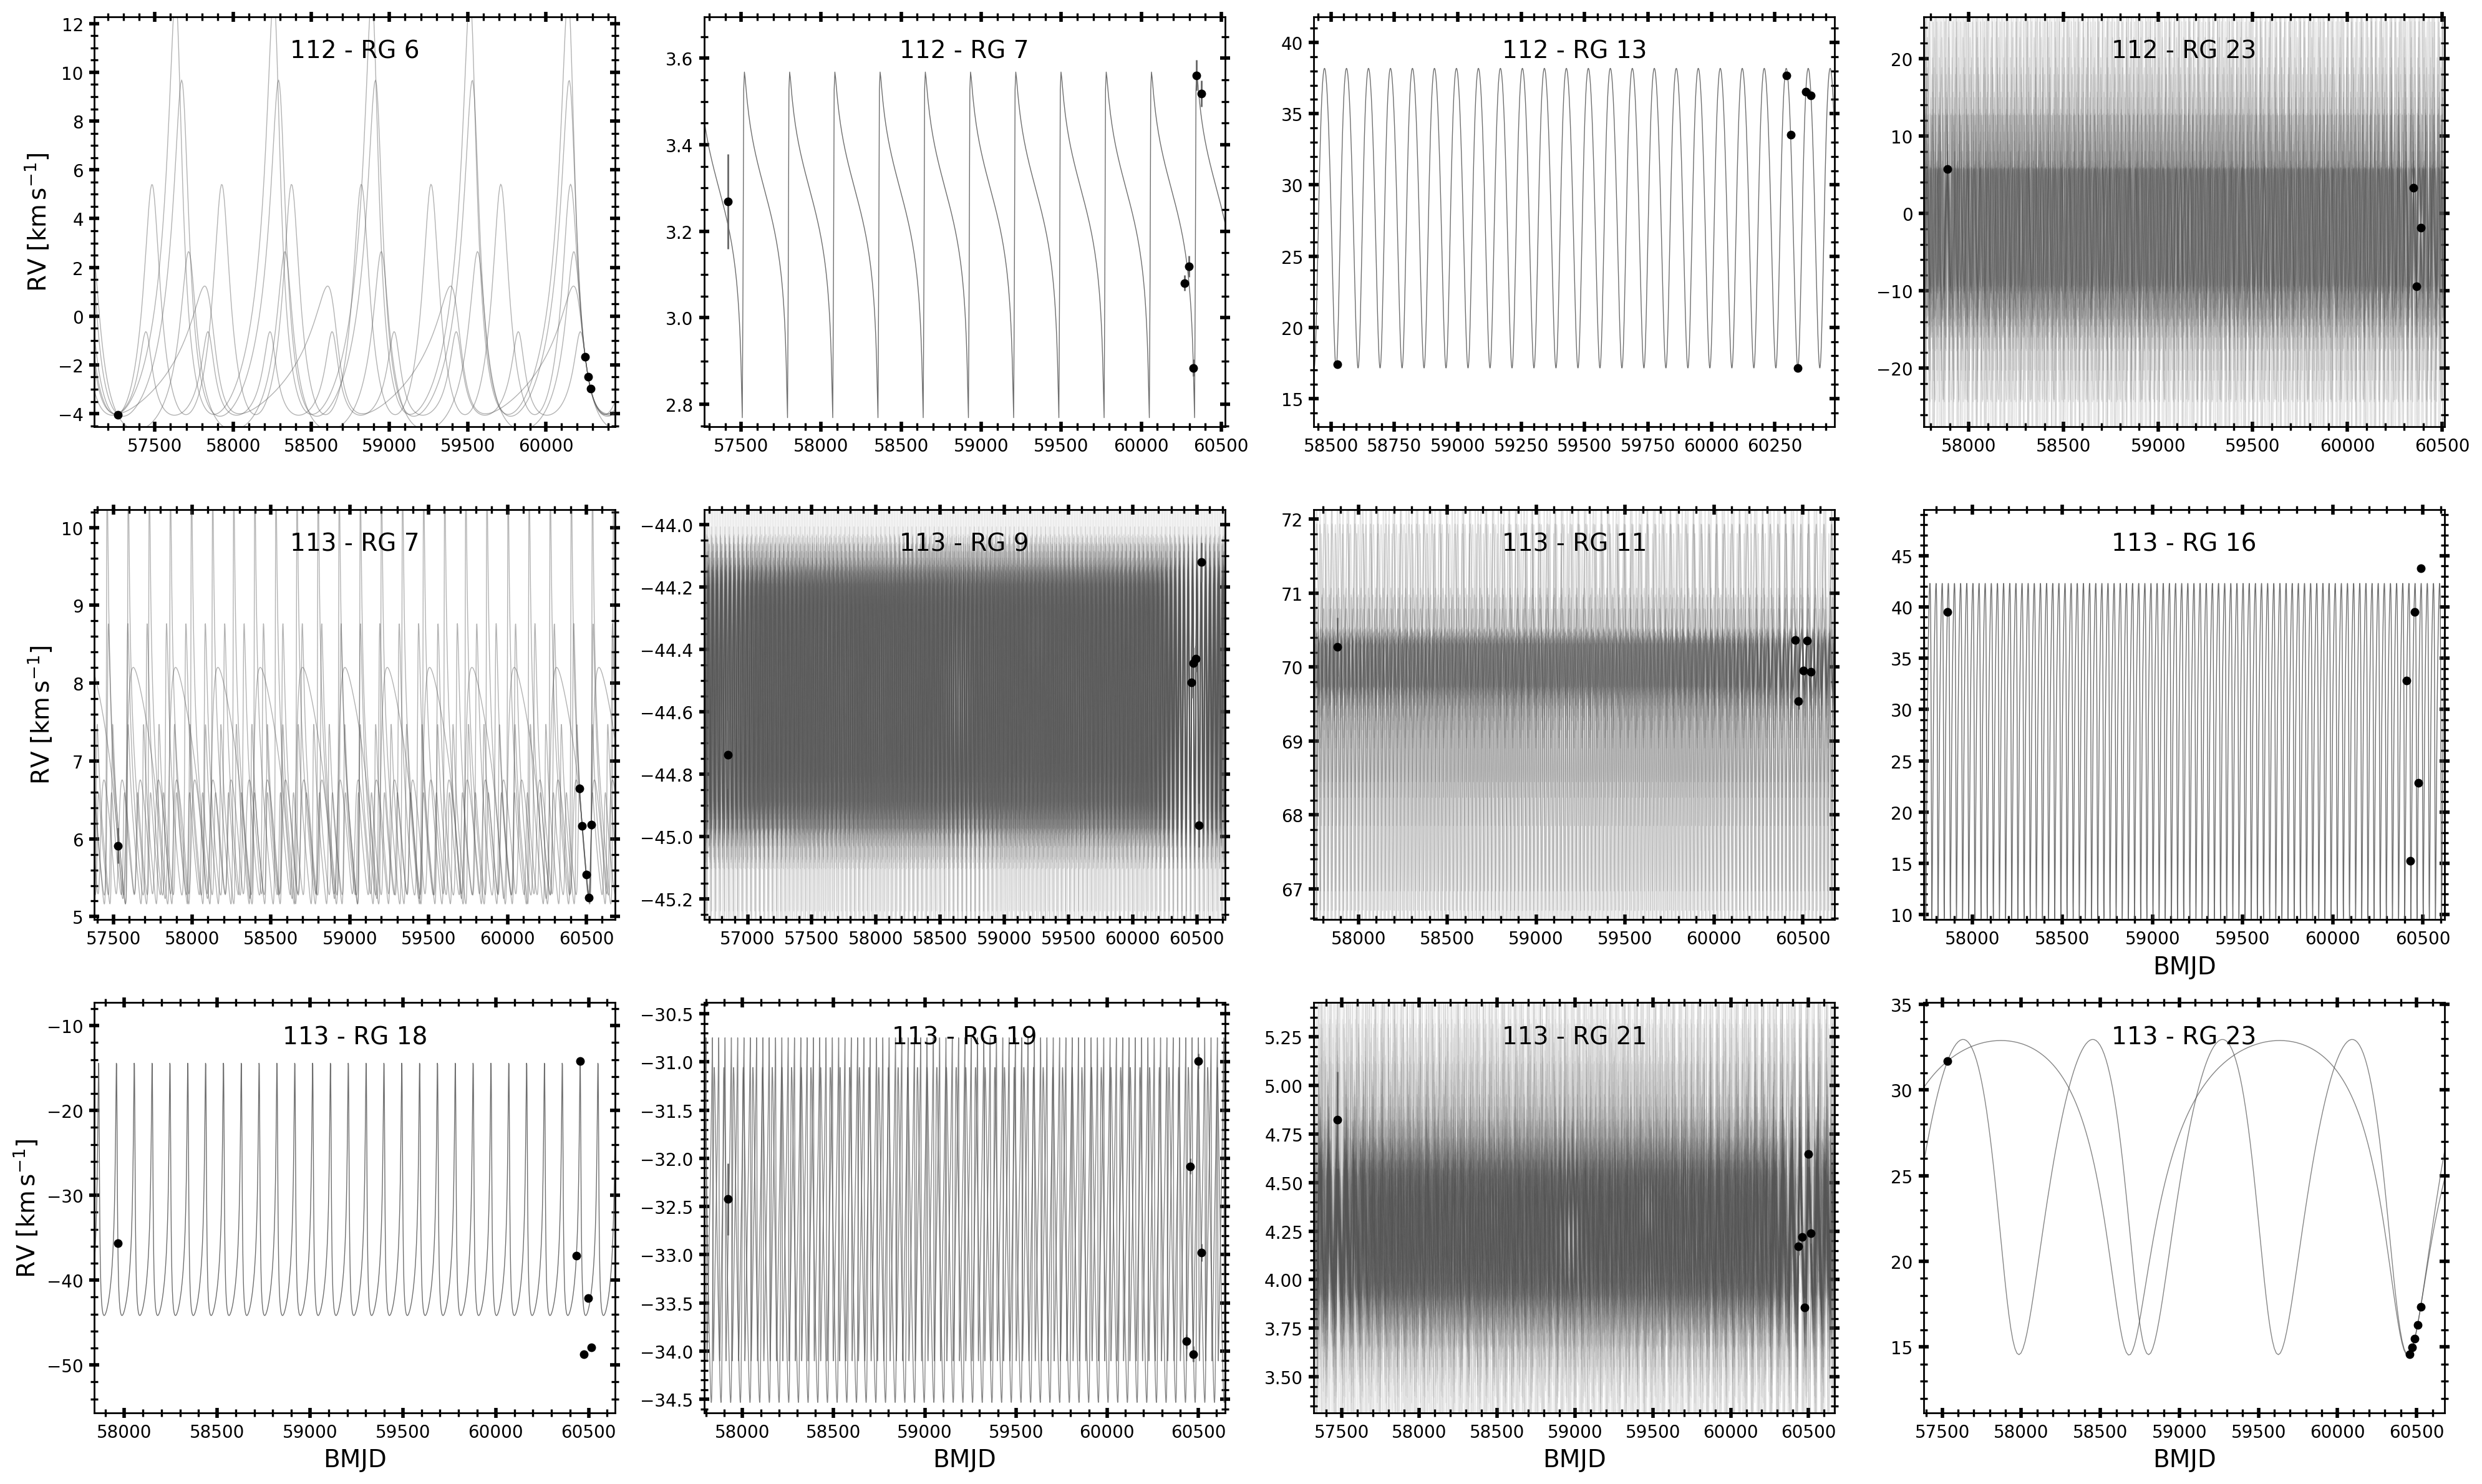

In [216]:
fig, axes = plt.subplots(3, 4, figsize=(20, 12),dpi=200)

for i, ax in enumerate(fig.axes):

    if i < len(binary_list_112):
        obj = binary_list_112[i]
        plot_joker_samples(rv_df, obj, program=112, ax=ax)
    elif i >= len(binary_list_112):
        obj = binary_list_113[i-len(binary_list_112)]
        plot_joker_samples(rv_df, obj, program=113, ax=ax)
    if i<7:
        ax.xaxis.label.set_visible(False)

        #ax.tick_params(axis='both', bottom=False, labelbottom=False)
    if i not in [0,4,8]:
        ax.yaxis.label.set_visible(False)
        #ax.tick_params(axis='both', left=False, labelleft=False)

plt.tight_layout()
# plt.savefig('../plots/all_joker_samples_%s.png'%DATE,bbox_inches='tight',dpi=200)


In [192]:
import thejoker as tj


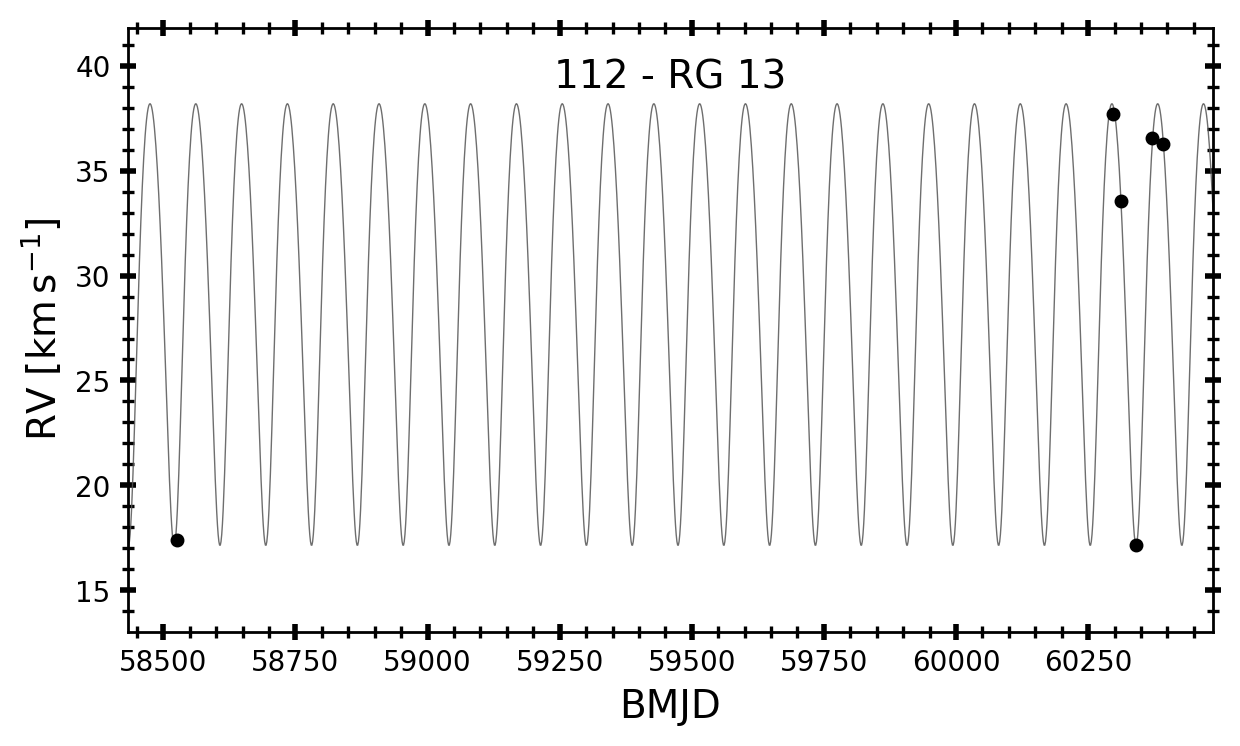

In [497]:
fig=plt.figure(figsize=(7,4),dpi=200)
ax=plt.subplot(111)
plot_joker_samples(rv_df, 13, program=112, ax=ax)

In [488]:
table3[['RG_id','program','vbroad','Li_val','e50','P50','Mj50']].sort_values(by='Li_val')

,RG_id,program,vbroad,Li_val,e50,P50,Mj50
1,9,113,12.10,1.54,0.065456,34.620994,6.587179
4,18,113,13.68,1.58,0.997206,95.724711,859.593829
2,11,113,30.59,1.64,0.193047,31.517923,10.781919
7,23,113,5.73,1.64,0.928916,1525.611398,618.815416
3,16,113,50.70,1.65,0.765700,34.236376,646.889855
0,6,112,7.95,1.79,0.615072,614.328998,278.224703
6,21,113,25.94,2.33,0.221503,55.167827,14.379512
1,7,112,10.03,2.60,0.669294,158.760071,14.245276
5,19,113,42.21,2.68,0.353373,54.001598,32.732248
2,13,112,19.17,3.34,0.263000,86.425657,1047.565515


In [500]:
table3[['RG_id','program','vbroad','Li_val','e50','P50','Mj50','v_max']].sort_values(by='e50')

,RG_id,program,vbroad,Li_val,e50,P50,Mj50,v_max
1,9,113,12.10,1.54,0.065456,34.620994,6.587179,68.876268
2,11,113,30.59,1.64,0.193047,31.517923,10.781919,103.180227
6,21,113,25.94,2.33,0.221503,55.167827,14.379512,94.008600
2,13,112,19.17,3.34,0.263000,86.425657,1047.565515,NaN
5,19,113,42.21,2.68,0.353373,54.001598,32.732248,83.848101
0,7,113,15.18,4.23,0.364026,122.559742,23.494917,65.365230
0,6,112,7.95,1.79,0.615072,614.328998,278.224703,63.903097
1,7,112,10.03,2.60,0.669294,158.760071,14.245276,109.447640
3,16,113,50.70,1.65,0.765700,34.236376,646.889855,221.572751
7,23,113,5.73,1.64,0.928916,1525.611398,618.815416,127.520159


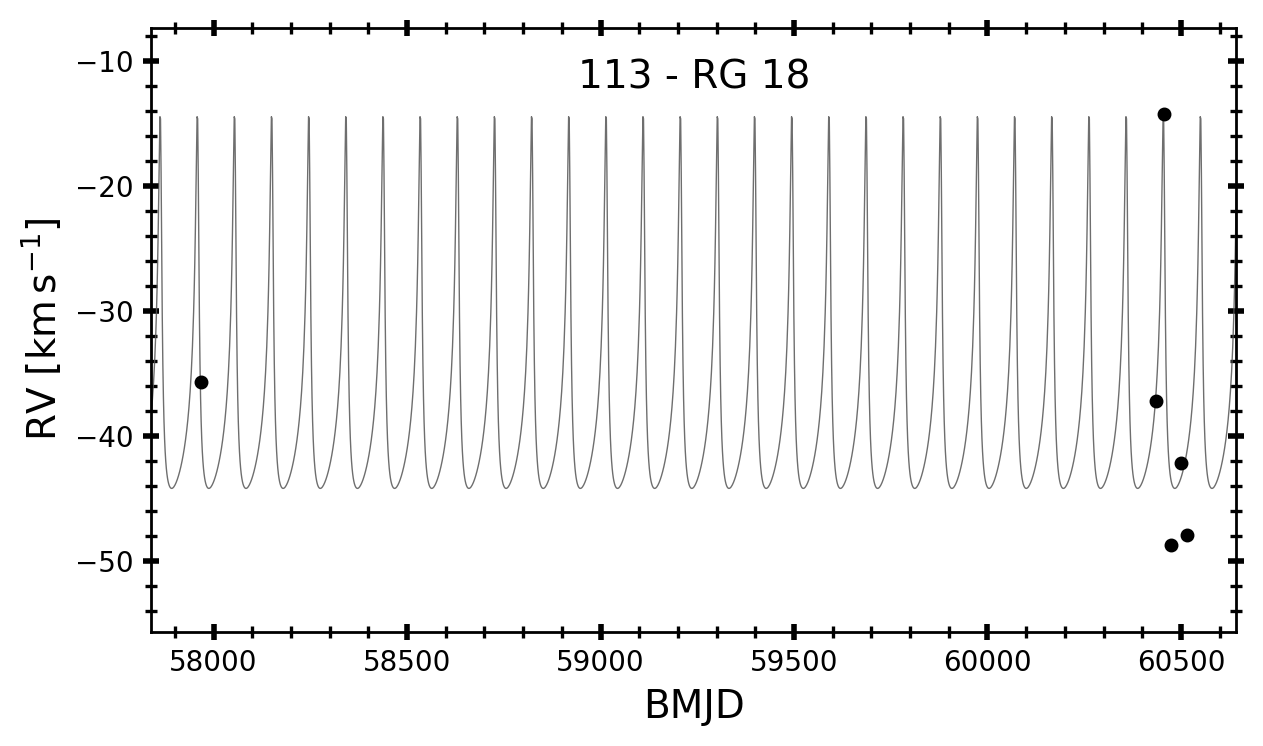

In [501]:
fig=plt.figure(figsize=(7,4),dpi=200)
ax=plt.subplot(111)
plot_joker_samples(rv_df, 18, program=113, ax=ax)

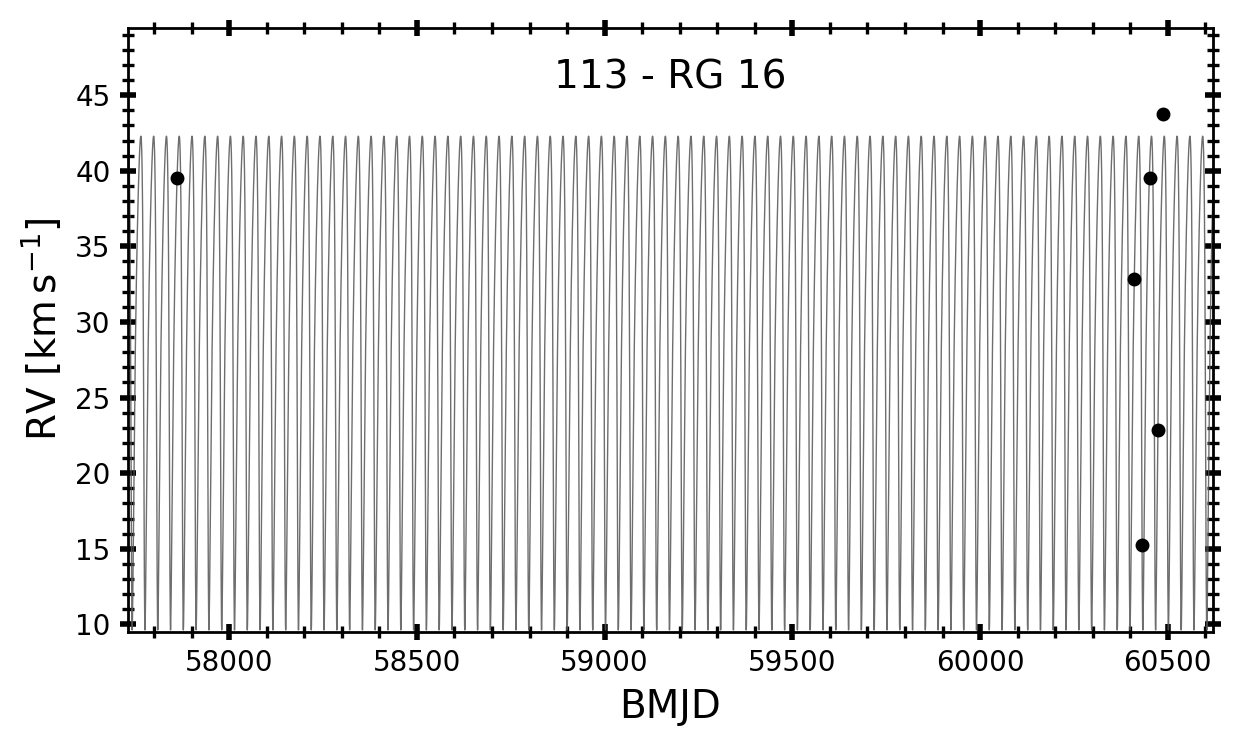

In [502]:
fig=plt.figure(figsize=(7,4),dpi=200)
ax=plt.subplot(111)
plot_joker_samples(rv_df, 16, program=113, ax=ax)

Index(['sobject_id', 'dr3_source_id_x', 'ra_dr2_x', 'dec_dr2_x', 'obj_name_x',
       'logg_x', 'teff_x', 'Li_val_x', 'vbroad_x', 'fe_h_x', 'ruwe_dr2_x',
       'teff_c', 'logg_c', 'feh_c', 'mgfe_c', 'cfe_c', 'nfe_c', 'DP_c',
       'Dnu_c', 'LogAge_c', 'teff_err', 'logg_err', 'feh_err', 'mgfe_err',
       'cfe_err', 'nfe_err', 'DP_err', 'Dnu_err', 'LogAge_err', 'chisq',
       'RG_id', 'Mj16', 'Mj50', 'Mj84', 'a16', 'a50', 'a84', 'P16', 'P50',
       'P84', 'e16', 'e50', 'e84', 'K16', 'K50', 'K84', 'logg_y', 'teff_y',
       'galah_id', 'obj_name_y', 'esp_time', 'esp_rv', 'esp_rv_err',
       'Li_val_y', 'e_Li_val', 'vbroad_y', 'e_vbroad', 'fe_h_y', 'ruwe_dr2_y',
       'Ba_fe', 'e_Ba_fe', 'La_fe', 'e_La_fe', 'Zr_fe', 'e_Zr_fe', 'Y_fe',
       'e_Y_fe', 'program', 'ra_dr2_y', 'dec_dr2_y', 'dr3_source_id_y',
       'MJD_local', 'rv_nogr_obst', 'e_rv_nogr_obst', 'rv_galah', 'e_rv_galah',
       'comb_time', 'comb_rv', 'comb_rv_err', 'm_act_bstep', 'e_m_act_bstep',
       'v_max', 'v_orb

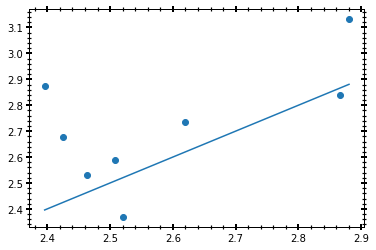

In [518]:
d1 = Table.read('../files/espresso_final_result.fits').to_pandas()
d2 = pd.merge(d1, table3, left_on='sobject_id',right_on='sobject_id')#.keys()
plt.scatter(d2.logg_c, d2.logg_x)
line=np.linspace(min(d2.logg_c), max(d2.logg_c),1000)
plt.plot(line,line)
d2.keys()

In [516]:
table3.keys()


12

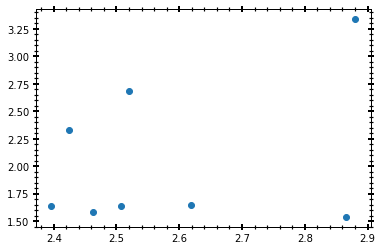

In [526]:
# plt.scatter(d2.logg_x, d2.Li_val_x)
plt.scatter(d2.logg_c, d2.Li_val_x)


(array([5., 1., 1., 0., 0.]),
 array([1.5, 2. , 2.5, 3. , 3.5, 4. ]),
 <BarContainer object of 5 artists>)

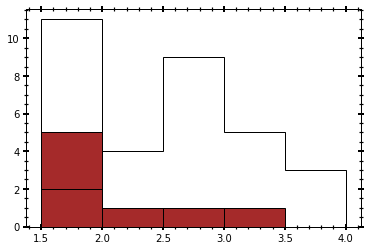

In [545]:
len(rv_df)
plt.figure(figsize=(6,4))
# plt.hist(rv_df.Li_val,bins=np.arange(1.5,4.5,0.5),color='lightgrey',zorder=-100)
plt.hist(rv_df.Li_val,bins=np.arange(1.5,4.5,0.5),histtype='step',color='k')

plt.hist(rv_df[(rv_df.RG_id.isin(binary_list_112)) & (rv_df.program==112)].Li_val,bins=np.arange(1.5,4.5,0.5),ec='k',histtype='step')
plt.hist(rv_df[(rv_df.RG_id.isin(binary_list_112)) & (rv_df.program==112)].Li_val,bins=np.arange(1.5,4.5,0.5),color=color)


plt.hist(rv_df[(rv_df.RG_id.isin(binary_list_113)) & (rv_df.program==113)].Li_val,bins=np.arange(1.5,4.5,0.5),ec='k',histtype='step')
plt.hist(rv_df[(rv_df.RG_id.isin(binary_list_113)) & (rv_df.program==113)].Li_val,bins=np.arange(1.5,4.5,0.5),color=color)


In [560]:
# pd.read_pickle("../data/gfinal_rich_low_fidelity.pkl")
    #dfr = dfr[~dfr.sobject_id.isin(df_rich.sobject_id)]
df_rich = pd.read_pickle('../../lithium/data/gfinal_rich.pkl')#.to_pandas()
df_rich

,star_id,sobject_id,dr2_source_id,dr3_source_id,survey_name,field_id,flag_repeat,wg4_field,wg4_pipeline,flag_sp,...,ecl_lat,zpt_ll2020,parallax_corr,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,flag_edr3dist
0,b'16500698-0416014',170711003001166,4377588177421757440,4377588177421757440,b'galah_main',5792,0,b'10k_15',b'lbol',0,...,18.065822,-0.039475,0.458106,2181.697998,2129.604980,2238.603271,2176.101074,2116.062988,2231.278564,b'10033'
1,b'21414287-6040576',170712005301104,6410046656998634240,6410046656998634240,b'galah_main',67,0,b'10k_27',b'lbol',0,...,-43.586924,-0.038508,0.440492,2272.267578,2204.915527,2347.613281,2259.387207,2196.129150,2336.085693,b'10033'
2,b'15401758-7033286',190211004301018,5819797032463791744,5819797032463791744,b'galah_main',3646,0,b'190211',b'lbol',0,...,-49.166473,-0.020183,1.040454,960.411133,949.624146,972.190735,961.524841,950.752380,976.030640,b'10033'
3,b'10092832-3940361',140414002601235,5420542335817018624,5420542335817018624,b'galah_main',4685,0,b'10k_20',b'lbol',0,...,-46.699062,-0.011144,0.486624,2062.099609,2019.227539,2111.842041,2062.752930,2024.999268,2099.080322,b'10033'
4,b'08594590-6859498',181221005601146,5223639384033034496,5223639384033034496,b'galah_main',2934,0,b'181221',b'lbol',0,...,-73.224262,-0.031017,0.336787,2961.916016,2872.487061,3033.177979,2936.579346,2855.856201,3011.511719,b'10033'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1094,b'11133468-3501511',160522002601353,5402146368112930176,5402146368112930176,b'galah_main',5779,0,b'10k_12',b'lbol',0,...,-36.311572,-0.039248,0.294207,3426.633301,3285.884521,3610.794434,3402.020752,3246.939941,3538.414795,b'10033'
1095,b'10263323-3635012',170411002101266,5445458918568326912,5445458918568326912,b'galah_main',5261,0,b'10k_21',b'lbol',0,...,-42.335558,-0.029105,0.359970,2775.227295,2670.228027,2894.538574,2805.670898,2709.334961,2913.451416,b'10033'
1096,b'17153907-1831501',170509005201178,4134423926739736960,4134423926739736960,b'k2_hermes',6746,0,b'10k_24',b'lbol',0,...,4.503991,-0.034998,0.714324,1398.677490,1345.525146,1442.741699,1416.174805,1370.445068,1465.576172,b'10033'
1097,b'18534662-1931420',170509007701056,4086088747075394560,4086088747075394560,b'k2_hermes',6675,0,b'10k_2',b'lbol',0,...,3.321128,-0.038344,1.562453,639.776306,630.831299,649.621521,639.474243,631.981201,646.076721,b'10033'


In [561]:
vac = pd.merge(df_rich, galah_vac, on='sobject_id')


In [567]:
np.nanmean(np.array(vac.e_m_act_bstep/vac.m_act_bstep)),np.nanmax(np.array(vac.e_m_act_bstep/vac.m_act_bstep))

(0.1828992381161126, 0.44862779752135845)

In [570]:
np.nanmean(np.array(vac.e_age_bstep/vac.age_bstep)),np.nanmin(np.array(vac.e_age_bstep/vac.age_bstep)),np.nanmax(np.array(vac.e_age_bstep/vac.age_bstep))

(0.4817124473535683, 0.06945330355712846, 3.0031494349167276)